### SENTIMENT ANALYSIS FOR TWITTER

In [1]:
# import required libraries

import pandas as pd
import numpy as np
import re
import spacy
import unicodedata

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# read the file as Pandas dataframe
df = pd.read_csv('twitter_data.csv', encoding = 'latin1')

### Data Visualization 

In [3]:
#check for empty cells

print(df.isna().sum())
print("luckily there are't any missing values".upper())

Unnamed: 0    0
sentiment     0
tweet         0
dtype: int64
LUCKILY THERE ARE'T ANY MISSING VALUES


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

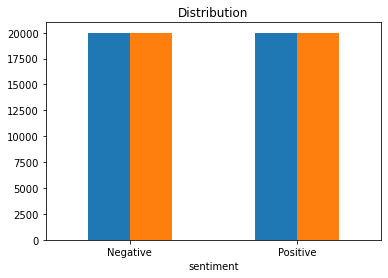

In [4]:
#print the distribution of data

ax = df.groupby('sentiment').count().plot(kind='bar',title='Distribution',legend=False)
ax.set_xticklabels(["Negative",'Positive'],rotation=0)

### Data Cleaning and Preprocessing

In [5]:
#convert to lower case

df["tweet"] = df["tweet"].apply(lambda x: str(x).lower())    

In [6]:
#making a dictionary of contractions

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"doesnt": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and ",
"won't": "would not",
'dis': 'this',
'bak': 'back',
'brng': 'bring',
'coz': 'because',
'cos': 'because'}

In [7]:
# Contraction to expansion

def contraction_conv(x):
    if(type(x) is str):
        for key in contractions:
            value = contractions[key]
            x = x.replace(key,value)
        return x
    else:
        return x

df['tweet'] = df['tweet'].apply(lambda x: contraction_conv(x))

In [8]:
# Count and removal of email IDs

df['emails'] = df['tweet'].apply(lambda x: re.findall(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)', x))
df['emails_count'] = df['emails'].apply(lambda x: len(x))
df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x))

In [9]:
# Count and removal of URL links

df['url_flags'] = df['tweet'].apply(lambda x: len(re.findall(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x)))
df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)) 

In [10]:
#special characters' removal

df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'[^\w ]+', "", x))   

In [11]:
# extra space removal

df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x.split()))

In [12]:
# Removal of accented chaacters

def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

df['tweet'] = df['tweet'].apply(lambda x: remove_accented_chars(x))

In [13]:
# Separation of stop words

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
df['tweet_no_stop'] = df['tweet'].apply(lambda x: ' '.join([t for t in x.split() if t not in stopwords]))

In [14]:
nlp = spacy.load('en_core_web_lg')

In [15]:
# Make the function to perform lemmatization

def make_to_base(x):
    x = str(x)
    x_list = []
    doc = nlp(x)
    
    for token in doc:
        lemma = token.lemma_
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text

        x_list.append(lemma)
    return ' '.join(x_list)

In [16]:
# Perform Lemmatization

df['tweet'] = df['tweet'].apply(lambda x: make_to_base(x))    #lemmatization

In [17]:
df.sample(5)

,Unnamed: 0,sentiment,tweet,emails,emails_count,url_flags,tweet_no_stop
36154,1596154,1,allison0704 I see a future quotallison shopsqu...,[],0,0,allison0704 future quotallison shopsquot post ...
16758,16758,0,madeleine is being bad,[],0,1,madeleine bad
7402,7402,0,ow my leg hurt today,[],0,0,ow leg hurts today
36266,1596266,1,my 2 favorite people to be around,[],0,1,2 favorite people
3845,3845,0,bah immune system finally give in it do so wel...,[],0,0,bah immune system finally gave year throat fee...


In [26]:
from textblob import TextBlob

for x in df["tweet"]:
    x = TextBlob(x).correct()

KeyboardInterrupt: 

In [28]:
df["tweet"].sample(5)

1127     grip agree love the sound but hate how everyon...
30921                barbarajwalter yes your tweet is work
28811                           casualcottage good morning
12239    dollyboox3 yeeeah do not laugh about I its wel...
27455    math final today then go out to get line vine ...
Name: tweet, dtype: object

In [30]:
# Find the least common 25 words and remove them
text = ' '.join(df['tweet'])
text = text.split()
freq_comm = pd.Series(text).value_counts()
rare25 = freq_comm.tail(25)
df['tweet'] = df['tweet'].apply(lambda x: ' '.join([t for t in x.split() if t not in rare25]))

In [31]:
# Check for empty rows after prerpocessing and remove them

emptyRows = df[df["tweet"] == ""].index
df.drop(emptyRows,inplace = True)

### MODEL DEPLOYMENT and TRAINING AND TESTING

In [32]:
# Make the model and store it as a callable function

def run_svm(df):
    X = df['tweet']
    y = df['sentiment']

    tfidf = TfidfVectorizer()
    X = tfidf.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

    print('shape of X: ', X.shape)

    clf = LinearSVC()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print()
    print('Printing Report')
    print(classification_report(y_test, y_pred))
    
    return tfidf, clf

In [33]:
# Call the function

tfidf, clf = run_svm(df)

shape of X:  (40000, 48180)

Printing Report
              precision    recall  f1-score   support

           0       0.78      0.77      0.77      4000
           1       0.77      0.78      0.77      4000

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



In [52]:
# Fine tuning the model

def run_svm(df):
    X = df['tweet']
    y = df['sentiment']

    tfidf = TfidfVectorizer(norm = 'l1')
    X = tfidf.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

    print('shape of X: ', X.shape)

    clf = LinearSVC()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print()
    print('Printing Report')
    print(classification_report(y_test, y_pred))
    
    return tfidf, clf

In [53]:
# results after fine tuning

tfidf, clf = run_svm(df)

shape of X:  (40000, 48180)

Printing Report
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      4000
           1       0.77      0.79      0.78      4000

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000



### SAMPLE TESTING

In [62]:
# Random sentence to check the model

x = ['i am not sad with this.']

In [63]:
# Define the function to check the model and check it

def predict_sentiment(x):
    sentiment = clf.predict(tfidf.transform(x))
    print(sentiment)

predict_sentiment(x)

[0]


In [64]:
import pickle

In [74]:
pickle.dump(clf, open('clf.pkl', 'wb'))
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))

In [75]:
del clf

In [76]:
del tfidf

In [77]:
clf=pickle.load(open("clf.pkl", "rb"))

In [78]:
tfidf=pickle.load(open("tlidf.pkl", "rb"))

In [80]:
#tfidf.vocabulary_

In [83]:
predict_sentiment(x)

[0]
